In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC

from utils import *
import pandas as pd
import numpy as np
import scipy as sci
import pdb
import os

# maui stuffs
import urllib.request
import matplotlib.lines as mlines
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc

Using TensorFlow backend.


In [4]:
def cluster(z, k=None, optimal_k_method='ami',optimal_k_range=range(3, 10), ami_y=None, kmeans_kwargs={'n_init': 1000, 'n_jobs': 2}):
    """Cluster the samples using k-means based on the latent factors.
    Parameters
    ----------
    k:                  optional, the number of clusters to find.
                        if not given, will attempt to find optimal k.
    optimal_k_method:   supported methods are 'ami' and 'silhouette'. Otherwise, callable.
                        if 'ami', will pick K which gives the best AMI
                        (adjusted mutual information) with external labels.
                        if 'silhouette' will pick the K which gives the best
                        mean silhouette coefficient.
                        if callable, should have signature ``scorer(yhat)``
                        and return a scalar score.
    optimal_k_range:    array-like, range of Ks to try to find optimal K among
    ami_y:              array-like (n_samples), the ground-truth labels to use
                        when picking K by "best AMI against ground-truth" method.
    kmeans_kwargs:      optional, kwargs for initialization of sklearn.cluster.KMeans
    Returns
    -------
    yhat:   Series (n_samples) cluster labels for each sample
    """
    
    if k is not None:
        return pd.Series(KMeans(k, **kmeans_kwargs).fit_predict(z), index=z.index)
    else:
        if optimal_k_method == 'ami':
            from sklearn.metrics import adjusted_mutual_info_score
            if ami_y is None:
                raise Exception(
                    "Must provide ``ami_y`` if using 'ami' to select optimal K.")

            z_to_use = z.loc[ami_y.index]
            scorer = lambda yhat: adjusted_mutual_info_score(ami_y, yhat)
        elif optimal_k_method == 'silhouette':
            from sklearn.metrics import silhouette_score
            z_to_use = z
            scorer = lambda yhat: silhouette_score(z_to_use, yhat)
        else:
            z_to_use = z
            scorer = optimal_k_method

        yhats = {k: pd.Series(KMeans(k, **kmeans_kwargs).fit_predict(z_to_use),
                              index=z_to_use.index) for k in optimal_k_range}
        score_name = optimal_k_method if isinstance(
            optimal_k_method, str) else optimal_k_method.__name__

        kmeans_scores = pd.Series(
            [scorer(yhats[k]) for k in optimal_k_range], index=optimal_k_range, name=score_name)
        kmeans_scores.index.name = 'K'
        optimal_k = np.argmax(kmeans_scores)
        yhat = yhats[optimal_k]

        return yhat, kmeans_scores


def compute_roc(z, y, classifier=LinearSVC(C=0.0001, max_iter=3000), cv_folds=10):  # C=0.001
    """Compute the ROC (false positive rate, true positive rate) using cross-validation.
    Parameters
    ----------
    z:          DataFrame (n_samples, n_latent_factors) of latent factor values
    y:          Series (n_samples,) of ground-truth labels to try to predict
    classifier: Classifier object to use, default ``LinearSVC(C=.001)``
    Returns
    -------
    roc_curves: dict, one key per class as well as "mean", each value is a dataframe
                containing the tpr (true positive rate) and fpr (falce positive rate)
                defining that class (or the mean) ROC.
    """
    class_names = sorted(y.unique())
    z_to_use = z.loc[y.index]
    y_true_bin = label_binarize(y, classes=class_names)
    y_proba = cross_val_predict(
        classifier, z_to_use, y, cv=cv_folds, method='decision_function')

    # Compute ROC curve and ROC area for each class
    roc_curves = dict()
    for i, cl_name in enumerate(class_names):
        fpr, tpr, thresholds = roc_curve(y_true_bin[:, i], y_proba[:, i])
        roc_curves[cl_name] = pd.concat([
            pd.Series(fpr, name='FPR'),
            pd.Series(tpr, name='TPR'),
        ], axis=1)

    mean_fpr = np.unique(np.concatenate(
        [roc_curves[cl_name].FPR for cl_name in class_names]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(mean_fpr)
    for cl_name in class_names:
        mean_tpr += interp(mean_fpr,
                           roc_curves[cl_name].FPR, roc_curves[cl_name].TPR)

    # Finally average it
    mean_tpr /= len(class_names)

    roc_curves["mean"] = pd.concat([
        pd.Series(mean_fpr, name='FPR'),
        pd.Series(mean_tpr, name='TPR'),
    ], axis=1)

    return roc_curves


def compute_auc(roc_curves, y, **kwargs):
    """Compute area under the ROC curve for predicting the labels in y using the
    latent features previously inferred.
    Parameters
    ----------
    y:          labels to predict
    **kwargs:   arguments for ``compute_roc``
    Returns:
    --------
    aucs:   pd.Series, auc per class as well as mean
    """
    # roc_curves = compute_roc(z, y, **kwargs)
    aucs = {k: auc(
        roc_curves[k].FPR,
        roc_curves[k].TPR) for k in roc_curves}
    return pd.Series(aucs)



In [9]:
def plotter(d, e):

    all_ids = pd.read_csv('model_outputs/' + d +
                          '/all.txt', sep=",", header=None)
    time = all_ids.iloc[:, 0]
    labels = all_ids.iloc[:, 1]
    ids = all_ids.iloc[:, 2]

    feature_names = pd.read_csv('model_outputs/' + d + '/feature_names.txt',
                                sep="\n", header=None)
    target_names = sorted(list(set(labels)))
    id_names = sorted(list(set(ids)))

    # loadings L=10
    ael_loadings = pd.read_csv(
        'model_outputs/' + d + '/loadings_' + e + '/ael_loadings.txt', sep=",", header=0)
    aer_loadings = pd.read_csv(
        'model_outputs/' + d + '/loadings_' + e + '/aer_loadings.txt', sep=",", header=0)
    fa_loadings = pd.read_csv(
        'model_outputs/' + d + '/loadings_' + e + '/fa_loadings.txt', sep=",", header=0)
    maui_loadings = pd.read_csv(
        'model_outputs/' + d + '/loadings_' + e + '/maui_loadings.txt', sep=",", header=0)
    mofa_loadings = pd.read_csv(
        'model_outputs/' + d + '/loadings_' + e + '/mfa_loadings.txt', sep=",", header=0)
    pca_loadings = pd.read_csv(
        'model_outputs/' + d + '/loadings_' + e + '/pca_loadings.txt', sep=",", header=0)

    # transformed L=10
    ael_transformed = pd.read_csv(
        'model_outputs/' + d + '/transformed_' + e + '/ael_transformed.txt', sep=",", header=0)
    aer_transformed = pd.read_csv(
        'model_outputs/' + d + '/transformed_' + e + '/aer_transformed.txt', sep=",", header=0)
    fa_transformed = pd.read_csv(
        'model_outputs/' + d + '/transformed_' + e + '/fa_transformed.txt', sep=",", header=0)
    maui_transformed = pd.read_csv(
        'model_outputs/' + d + '/transformed_' + e + '/maui_transformed.txt', sep=",", header=0)
    mofa_transformed = pd.read_csv(
        'model_outputs/' + d + '/transformed_' + e + '/mfa_transformed.txt', sep=",", header=0)
    pca_transformed = pd.read_csv(
        'model_outputs/' + d + '/transformed_' + e + '/pca_transformed.txt', sep=",", header=0)

    # plot latent factor representation (describe variation in data, across
    # different omics types)

    # filter out all labels except CMS
    if d == "tcga":
        y = labels
        yi = ids
        # gex = pd.read_csv(os.path.join('data', 'gex.csv'), index_col=0)
        y_cmsonly = y[y != 'NOLBL']
        yi_cmsonly = yi[y != 'NOLBL']
        y = list(y_cmsonly)
        yi = list(yi_cmsonly)
        labels = y_cmsonly
        target_names = sorted(list(set(labels)))

    else:
        y = list(labels)
        yi = list(ids)

    title_strings = ["AEL", "AER", "FA", "VAE", "MFA", "PCA"]
    transformed = [ael_transformed, aer_transformed, fa_transformed,
                   maui_transformed, mofa_transformed, pca_transformed]
    loadings = [ael_loadings, aer_loadings, fa_loadings,
                maui_loadings, mofa_loadings, pca_loadings]
    
    
    # error check the header
    for l in loadings:
        header = list(l)
        try:
            int(header[0])
        except ValueError:
            l.columns = list(range(30))
    

    # X_filtered = pd.read_csv(
    #     "data/X_" + d + "_filtered.csv", header=0, index_col=0)
    # X = X_filtered

    save_path = 'model_outputs/' + d + "/" + e + "_"
    for i, z in enumerate(transformed):

        # fig path titles
        t = title_strings[i]

        # scatter - by label (PCA)
        plt.figure()
        cmap = dict(zip(target_names, sns.color_palette()))
        ycols = [cmap[l] for l in y]

        legend_handles = [mlines.Line2D([], [], color=cmap[label], label=label, marker='o',
                                        markersize=10, linewidth=0) for label in cmap]
        pcs = pd.DataFrame(TSNE(2).fit_transform(z), columns=[
                           'PC1', 'PC2'], index=z.index).loc[labels.index]
        pcs.plot.scatter(x='PC1', y='PC2', c=ycols)
        plt.title(title_strings[i])
        plt.legend(handles=legend_handles)
        plt.savefig(save_path + t + "_scatter")

        # scatter - by sample id (PCA)
        plt.figure()
        cmap = dict(zip(id_names, sns.color_palette(n_colors=len(id_names))))
        ycols = [cmap[l] for l in yi]

        legend_handles = [mlines.Line2D([], [], color=cmap[label], label=label, marker='o',
                                        markersize=10, linewidth=0) for label in cmap]
        pcs = pd.DataFrame(TSNE(2).fit_transform(z), columns=[
                           'PC1', 'PC2'], index=z.index).loc[labels.index]
        pcs.plot.scatter(x='PC1', y='PC2', c=ycols)
        plt.title(title_strings[i])
        # plt.legend(handles=legend_handles)
        plt.savefig(save_path + t + "_scatterid")

        # scree
        plt.figure()
        pca_trafo = PCA().fit(z)
        plt.semilogy(pca_trafo.explained_variance_ratio_,
                     '--o', label="Explained variance ratio")
        plt.semilogy(pca_trafo.explained_variance_ratio_.cumsum(),
                     '--o', label="Cumulative explained var ratio")
        plt.title(t)
        plt.legend()
        plt.xlabel("PC")
        plt.ylabel("Explained variance ratio")
        plt.savefig(save_path + t + "_scree")

        # cluster k-selection
        plt.figure()
        yhat, kmeans_scores = cluster(z, ami_y=labels)
        kmeans_scores.plot()
        plt.ylabel("AMI")
        plt.xlabel("K")
        plt.title(t)
        plt.savefig(save_path + t + "_kselect")

        # clustering
        plt.figure()
        cmap_clusters = dict(zip(sorted(yhat.unique()), sns.color_palette()))
        ycols_clusters = [cmap_clusters[l] for l in yhat]
        legend_handles = [mlines.Line2D([], [], color=cmap_clusters[label], label=label, marker='o',
                                        markersize=10, linewidth=0) for label in cmap_clusters]

        pcs = pd.DataFrame(PCA(2).fit_transform(z), columns=[
                           'PC1', 'PC2'], index=z.index).loc[labels.index]
        pcs.plot.scatter(x='PC1', y='PC2', c=ycols_clusters)
        plt.legend(handles=legend_handles)
        plt.title(t)
        plt.savefig(save_path + t + "_cluster")

        # roc
        fig, ax = plt.subplots()
        if d == "arabidop2":
            rocs = compute_roc(scale(z), labels, cv_folds=2)
        elif d == "ipop" or d == "tcga":
            rocs = compute_roc(scale(z), labels)

        aucs = compute_auc(rocs, labels)
        print(aucs)

        for i, k in enumerate(rocs):
            rocs[k].plot(
                'FPR', 'TPR', ax=ax, label='ROC curve, class {0} (auc = {1:0.2f})'.format(k, aucs[k]))

        plt.ylabel("TPR")
        plt.title(t)
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.savefig(save_path + t + "_roc")

        # # activations/weights
        # plt.figure()
        # sns.heatmap(loadings[i].T, annot=False, center=0,
        #             yticklabels=False, xticklabels=False)
        # plt.title(t)
        # plt.xlabel("PC")
        # plt.ylabel("Omic features")
        # plt.savefig(save_path + t + "_weights")

        # # pearson correlation - of latent factors with input features
        # plt.figure()
        # feature_s = map_factors_to_features(z, X, pval_threshold=.001)
        # df = feature_s
        # print(df.shape)
        # sns.heatmap(df, annot=False, center=0, yticklabels=False)
        # plt.title(t)
        # plt.xlabel("PC")
        # plt.ylabel("Samples")
        # # ax.get_legend().remove()
        # plt.savefig(save_path + t + "_pearson")
        # # plt.pcolor(df)
        # # plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
        # # plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
        # # plt.show()



# iPOP dataset

Healthy        0.536792
Infection      0.569514
Infection_L    0.471837
mean           0.528077
dtype: float64
Healthy        0.513265
Infection      0.512535
Infection_L    0.542226
mean           0.524740
dtype: float64
Healthy        0.520705
Infection      0.578758
Infection_L    0.473024
mean           0.526436
dtype: float64
Healthy        0.462881
Infection      0.506629
Infection_L    0.436327
mean           0.470870
dtype: float64
Healthy        0.529385
Infection      0.571312
Infection_L    0.490575
mean           0.532662
dtype: float64
Healthy        0.538212
Infection      0.565173
Infection_L    0.471243
mean           0.527221
dtype: float64


<Figure size 432x288 with 0 Axes>

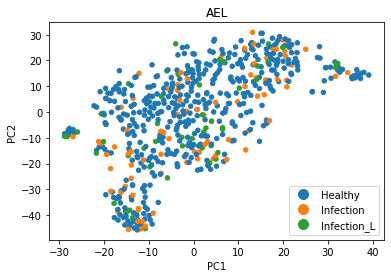

<Figure size 432x288 with 0 Axes>

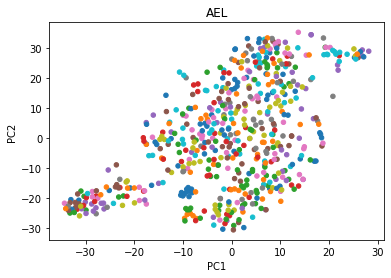

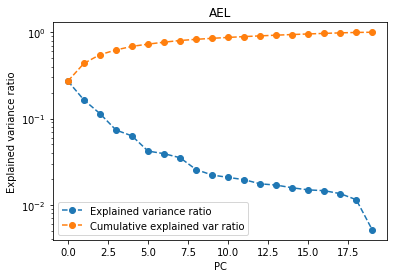

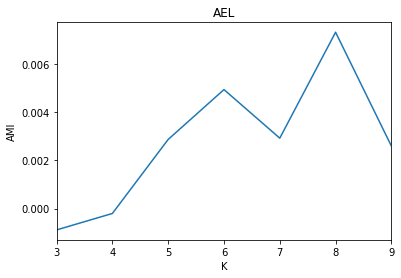

<Figure size 432x288 with 0 Axes>

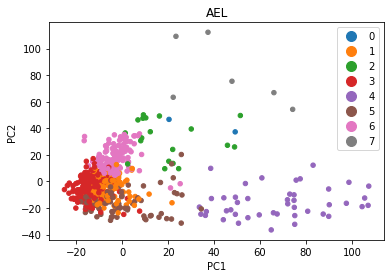

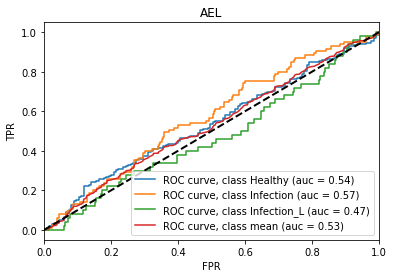

<Figure size 432x288 with 0 Axes>

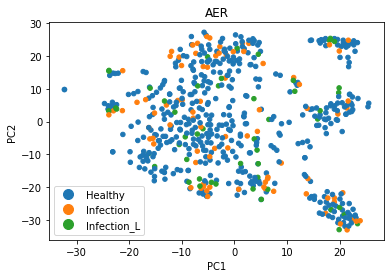

<Figure size 432x288 with 0 Axes>

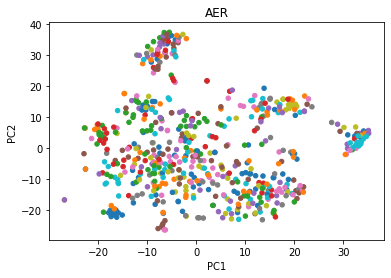

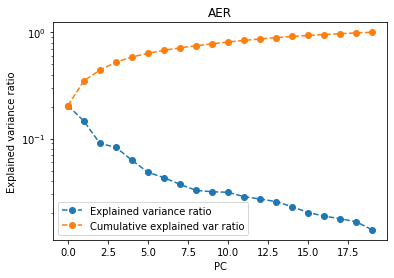

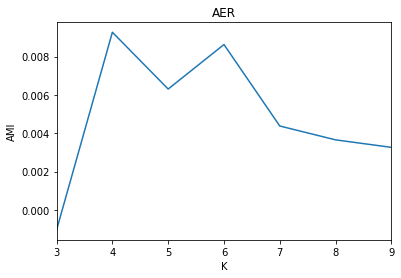

<Figure size 432x288 with 0 Axes>

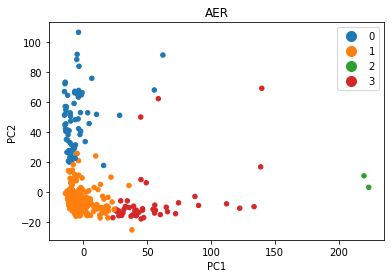

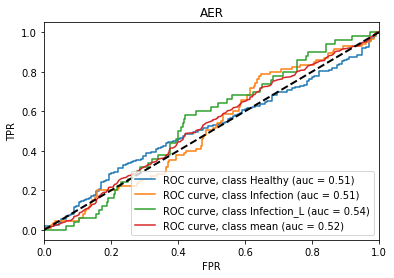

<Figure size 432x288 with 0 Axes>

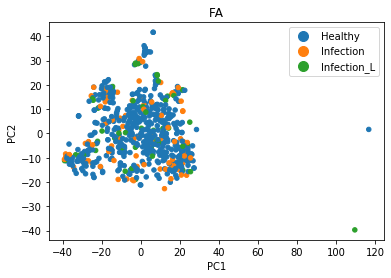

<Figure size 432x288 with 0 Axes>

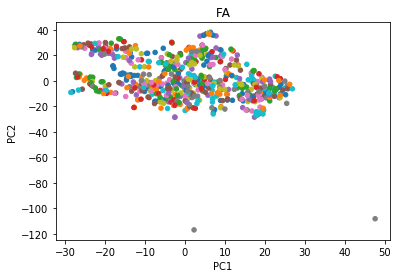

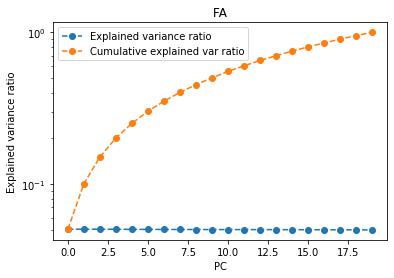

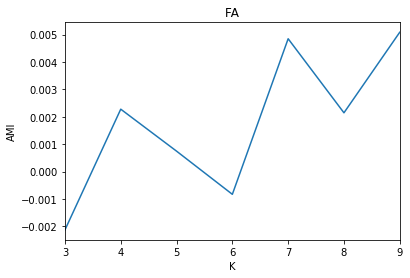

<Figure size 432x288 with 0 Axes>

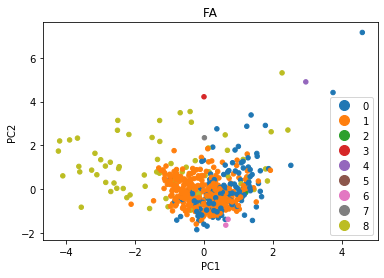

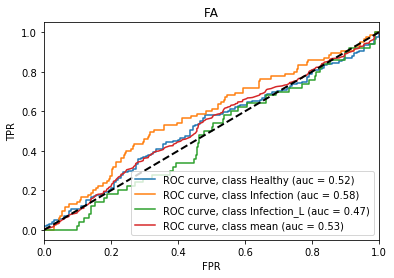

<Figure size 432x288 with 0 Axes>

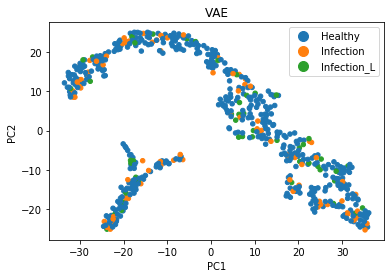

<Figure size 432x288 with 0 Axes>

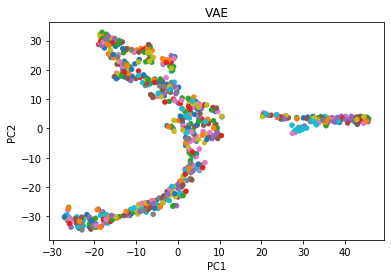

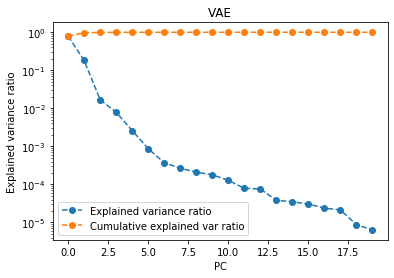

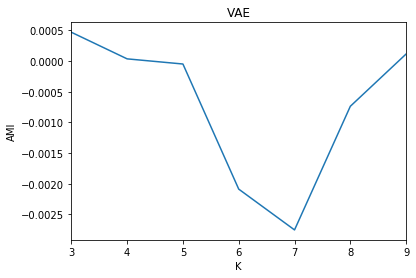

<Figure size 432x288 with 0 Axes>

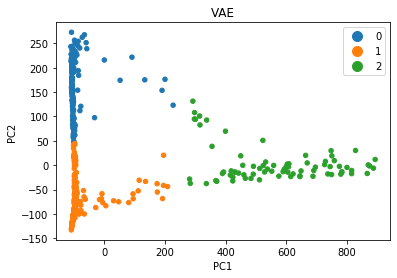

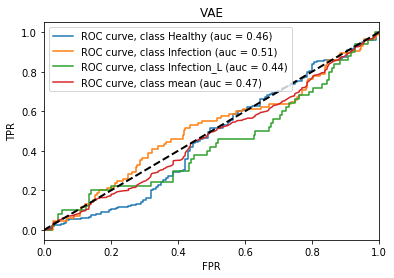

<Figure size 432x288 with 0 Axes>

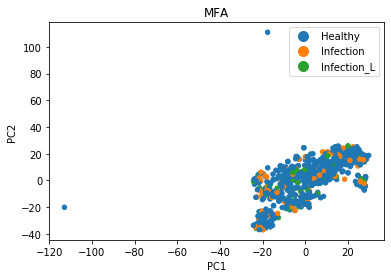

<Figure size 432x288 with 0 Axes>

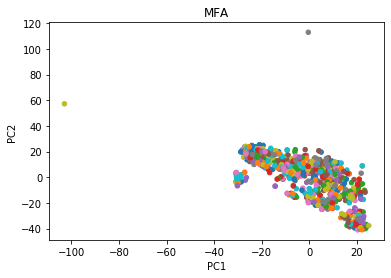

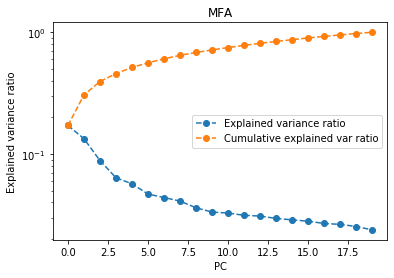

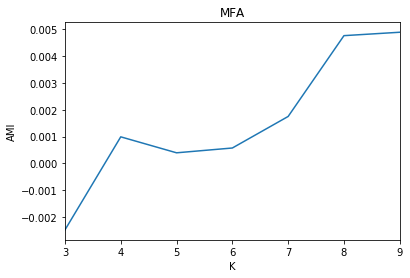

<Figure size 432x288 with 0 Axes>

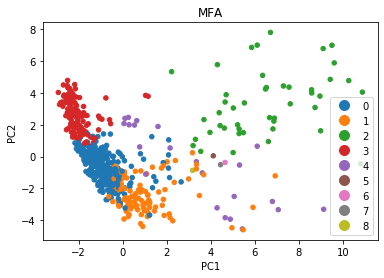

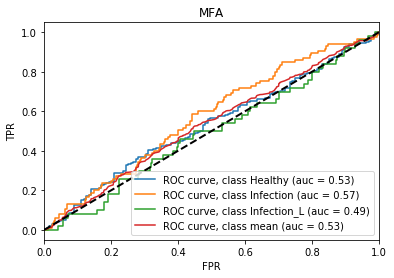

<Figure size 432x288 with 0 Axes>

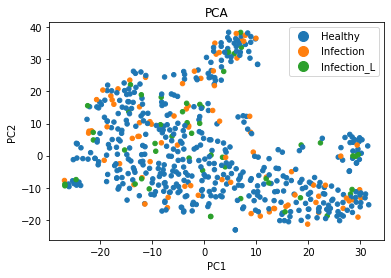

<Figure size 432x288 with 0 Axes>

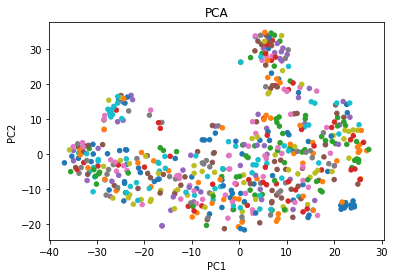

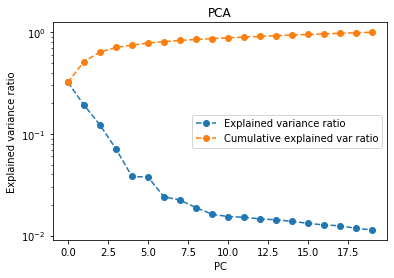

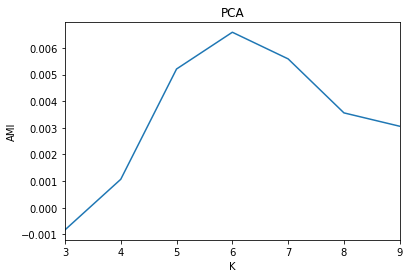

<Figure size 432x288 with 0 Axes>

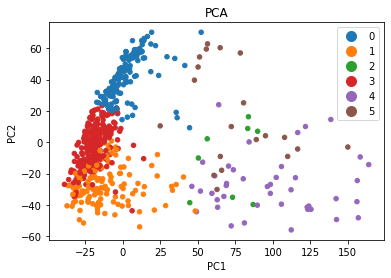

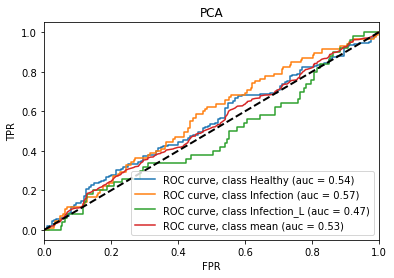

In [6]:
d = "ipop"
e = str(20)
plotter(d,e)

# TCGA dataset

CMS1    0.461009
CMS2    0.529826
CMS3    0.504577
CMS4    0.503812
mean    0.501207
dtype: float64
CMS1    0.518409
CMS2    0.486722
CMS3    0.534249
CMS4    0.466127
mean    0.502701
dtype: float64
CMS1    0.525169
CMS2    0.507705
CMS3    0.547159
CMS4    0.487640
mean    0.518354
dtype: float64
CMS1    0.530390
CMS2    0.526339
CMS3    0.525000
CMS4    0.494924
mean    0.520477
dtype: float64
CMS1    0.528911
CMS2    0.505931
CMS3    0.531660
CMS4    0.479752
mean    0.512912
dtype: float64
CMS1    0.523358
CMS2    0.521606
CMS3    0.504735
CMS4    0.504076
mean    0.514773
dtype: float64


<Figure size 432x288 with 0 Axes>

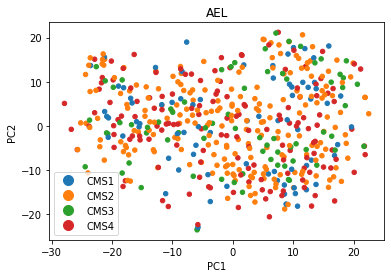

<Figure size 432x288 with 0 Axes>

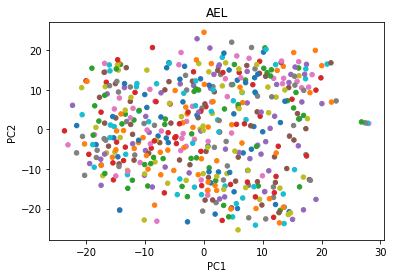

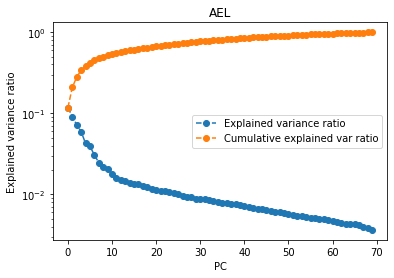

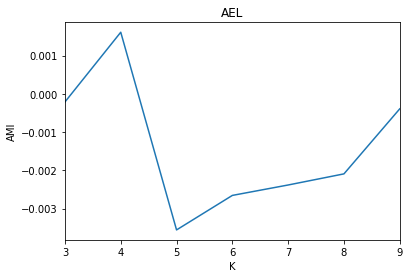

<Figure size 432x288 with 0 Axes>

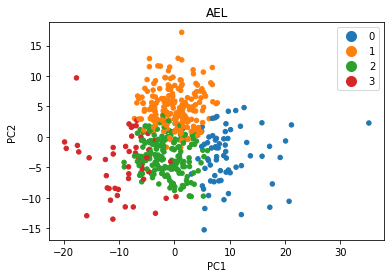

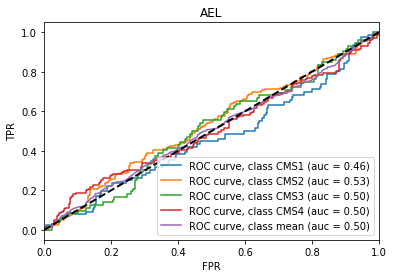

<Figure size 432x288 with 0 Axes>

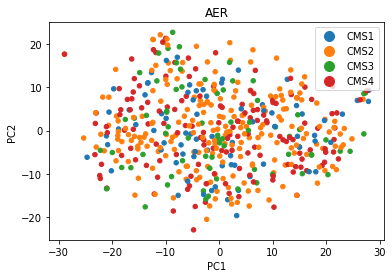

<Figure size 432x288 with 0 Axes>

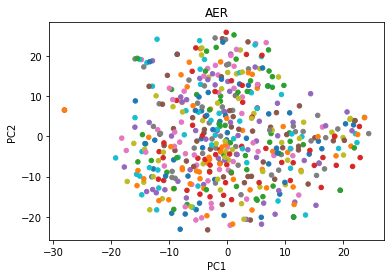

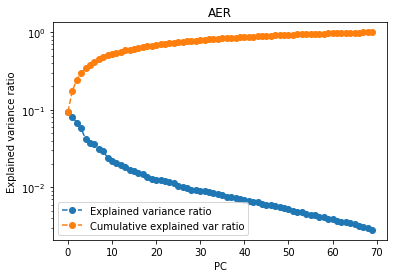

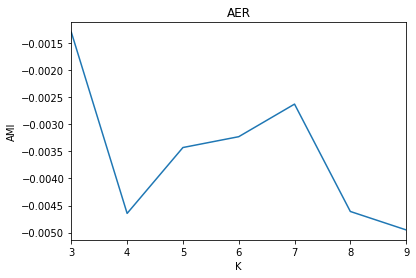

<Figure size 432x288 with 0 Axes>

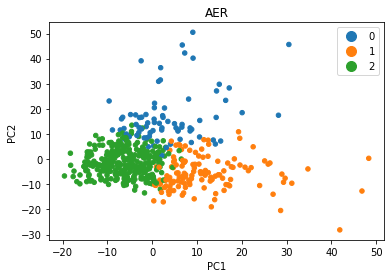

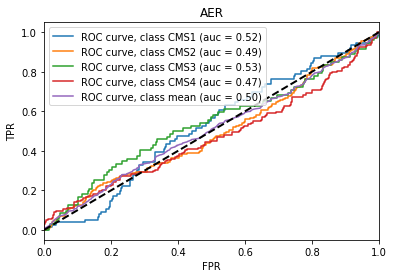

<Figure size 432x288 with 0 Axes>

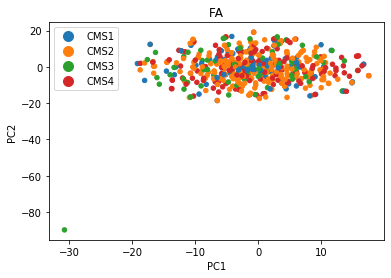

<Figure size 432x288 with 0 Axes>

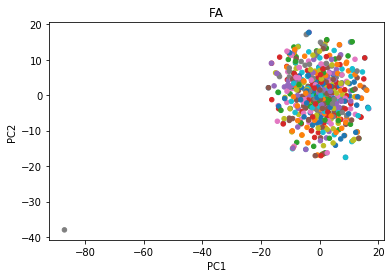

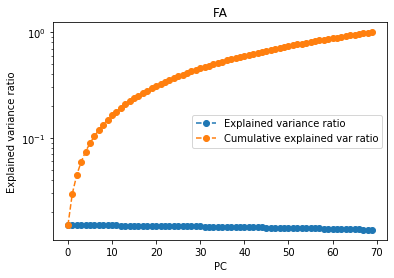

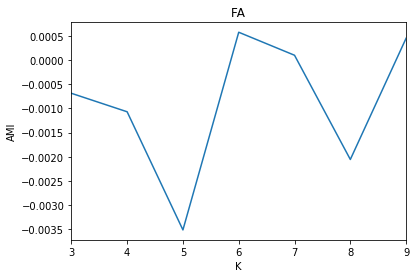

<Figure size 432x288 with 0 Axes>

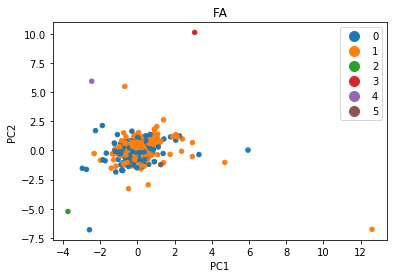

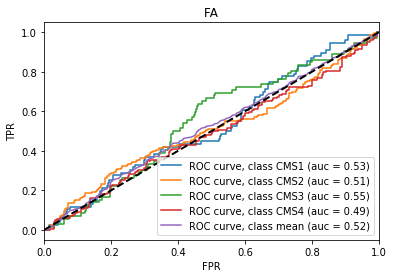

<Figure size 432x288 with 0 Axes>

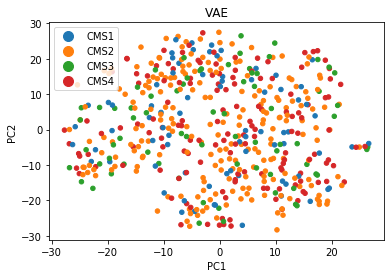

<Figure size 432x288 with 0 Axes>

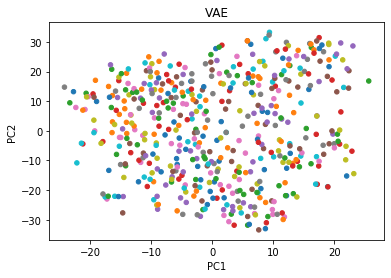

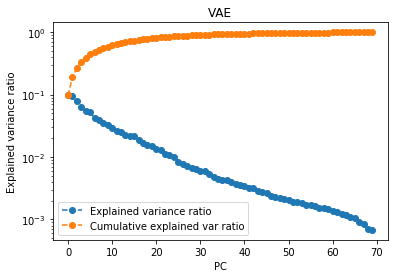

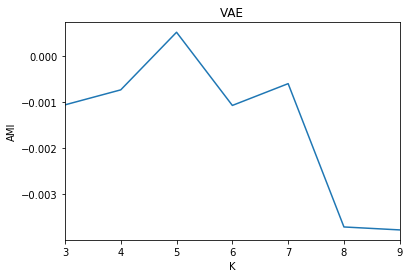

<Figure size 432x288 with 0 Axes>

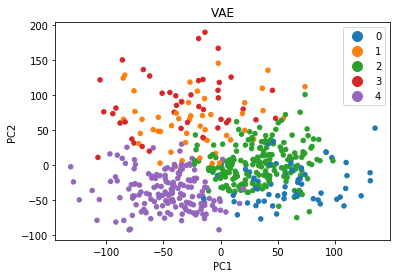

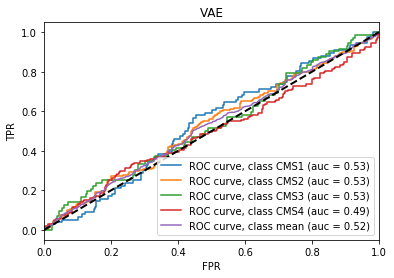

<Figure size 432x288 with 0 Axes>

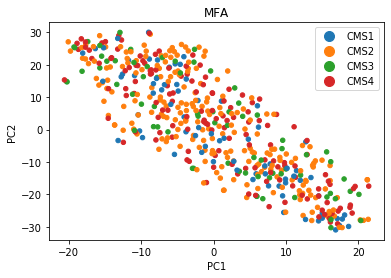

<Figure size 432x288 with 0 Axes>

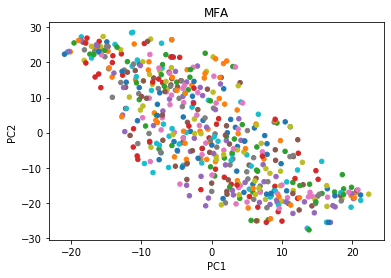

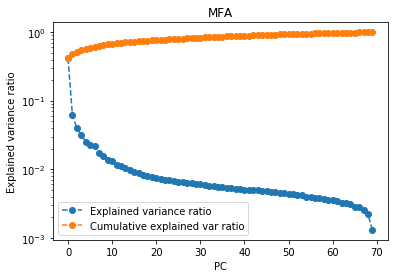

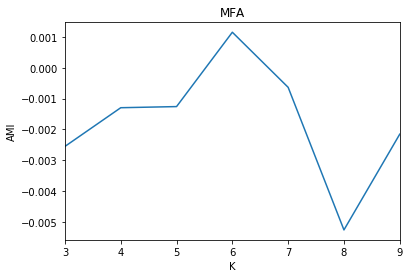

<Figure size 432x288 with 0 Axes>

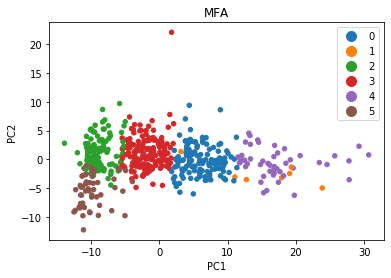

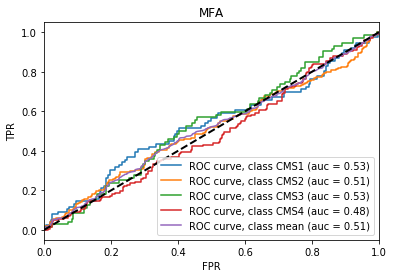

<Figure size 432x288 with 0 Axes>

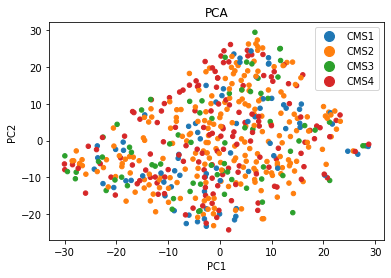

<Figure size 432x288 with 0 Axes>

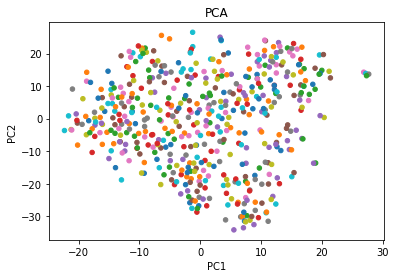

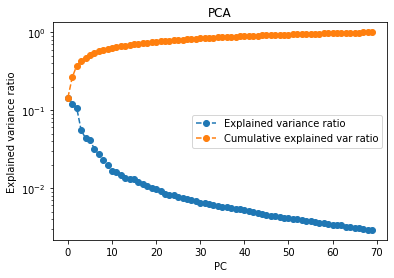

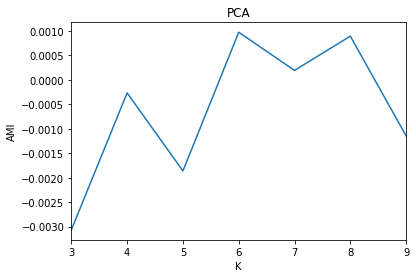

<Figure size 432x288 with 0 Axes>

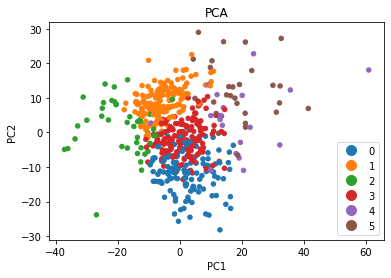

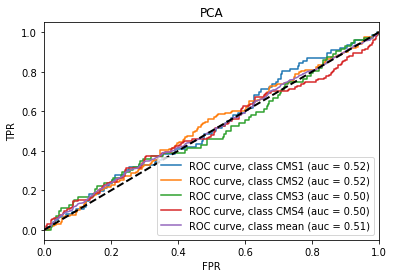

In [12]:
d = "tcga"
e = str(70)
plotter(d,e)

# Pioneer dataset

In [ ]:
d = "pioneer"
e = str(10)
plotter(d,e)